In [2]:
# import libraries for Twitter API and model

In [3]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


In [5]:
from textblob import TextBlob
import tweepy
import sys
import datetime, time
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sharraeallen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharraeallen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
api_key = 'HkE5YJuv01c4bbq1GVc8SfNo4'
api_key_secret = 'fdSpo4SJjOKgDBtitXcKZ4s6Oe2KAgZDtwGoQ1JFoZre02AjT4'
access_token = '455536583-boFHn3N5TG6dDrTT0sJHbB0ehyzHyRZkakLCSkQ3'
access_token_secret = 'Ygw5qCpWu0RLL3KJnt3SKzjUqgQg1rtkUdJPVuDSeDROU'

auth_handler = tweepy.OAuthHandler(consumer_key=api_key, consumer_secret=api_key_secret)
auth_handler.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth_handler)

### GOP account into dataframe

In [8]:
## Official GOP account

In [9]:
user = 'GOP' 
posts = tweepy.Cursor(api.user_timeline, screen_name=user).items(limit = 5000)
tweets1 = []

for status in posts:
      if status.lang == 'en':
        data = {'user': [status.user.name],
        'account_name':['@'+status.user.screen_name], 
        'tweet': [status.text]}
        tweets1.append(data)

df_gop = pd.DataFrame(tweets1)

df_gop.head()

,user,account_name,tweet
0,[GOP],[@GOP],[Congratulations to Christine Drazan on winnin...
1,[GOP],[@GOP],[We’re celebrating #AAPIHeritageMonth by highl...
2,[GOP],[@GOP],[🚨New from @GOPChairwoman: Primary elections s...
3,[GOP],[@GOP],[The APA community is finding a home in the Re...
4,[GOP],[@GOP],[RT @nicolemoralesdc: 🚨POLLING ON HISPANIC VOT...


In [10]:
df_gop.shape

(3188, 3)

In [11]:
df_gop

,user,account_name,tweet
0,[GOP],[@GOP],[Congratulations to Christine Drazan on winnin...
1,[GOP],[@GOP],[We’re celebrating #AAPIHeritageMonth by highl...
2,[GOP],[@GOP],[🚨New from @GOPChairwoman: Primary elections s...
3,[GOP],[@GOP],[The APA community is finding a home in the Re...
4,[GOP],[@GOP],[RT @nicolemoralesdc: 🚨POLLING ON HISPANIC VOT...
...,...,...,...
3183,[GOP],[@GOP],[This is UNACCEPTABLE.\nhttps://t.co/a569Rookw2]
3184,[GOP],[@GOP],[Joe Biden finally admitted the border is not ...
3185,[GOP],[@GOP],[Listen to @KimReynoldsIA share with @GOPChair...
3186,[GOP],[@GOP],[Biden’s speech at the UN is a reminder he has...


In [12]:
df_gop.columns

Index(['user', 'account_name', 'tweet'], dtype='object')

In [13]:
#Separate the text of the tweets
gop_tweet = df_gop.drop(['user', 'account_name'], axis=1)
gop_tweet.head()

,tweet
0,[Congratulations to Christine Drazan on winnin...
1,[We’re celebrating #AAPIHeritageMonth by highl...
2,[🚨New from @GOPChairwoman: Primary elections s...
3,[The APA community is finding a home in the Re...
4,[RT @nicolemoralesdc: 🚨POLLING ON HISPANIC VOT...


In [14]:
print(gop_tweet['tweet'].iloc[0],'\n')
print(gop_tweet['tweet'].iloc[1],'\n')
print(gop_tweet['tweet'].iloc[2],'\n')
print(gop_tweet['tweet'].iloc[3],'\n')
print(gop_tweet['tweet'].iloc[4],'\n')

['Congratulations to Christine Drazan on winning the Republican primary for Governor of Oregon! Oregonians are ready… https://t.co/iFKrU1Py1B'] 

['We’re celebrating #AAPIHeritageMonth by highlighting some amazing Asian Americans in the Republican Party!… https://t.co/zhqGLhZxbM'] 

["🚨New from @GOPChairwoman: Primary elections show Biden is 'underwater' as Americans suffer from economic woes\nhttps://t.co/LiZISIdEgA"] 

['The APA community is finding a home in the Republican Party. \n \nDuring #AAPIHeritageMonth the GOP highlighted APA l… https://t.co/0jtXThAoFG'] 

['RT @nicolemoralesdc: 🚨POLLING ON HISPANIC VOTERS:\n\n📉60% disapprove of the way Biden is handling his job as president\n\n📉66% disapprove of th…'] 



In [15]:
gop_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3188 entries, 0 to 3187
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   3188 non-null   object
dtypes: object(1)
memory usage: 25.0+ KB


## Cleaning

In [16]:
# Cleaning data with RegEx functions to remove symbols, punctuation, retweet labels, and links

def cleaning_round1(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",str(tweet)) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", str(tweet)) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    return tweet

In [17]:
gop_tweet['tweet'] = gop_tweet['tweet'].map(lambda x: cleaning_round1(x))
gop_tweet

,tweet
0,['Congratulations to Christine Drazan on winni...
1,['We’re celebrating AAPIHeritageMonth by highl...
2,"[""🚨New from : Primary elections show Biden is ..."
3,['The APA community is finding a home in the R...
4,['RT : 🚨POLLING ON HISPANIC VOTERS:\n\n📉60% di...
...,...
3183,['This is UNACCEPTABLE.\n
3184,['Joe Biden finally admitted the border is not...
3185,['Listen to share with how Republican leadersh...
3186,['Biden’s speech at the UN is a reminder he ha...


In [18]:
# Removing punctuation and brackets 

def cleaning_round2(tweet):
    tweet = str(tweet).lower()
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub(r'\brt\b', '',tweet).strip() #Remove 'rt' as retweet label
    tweet = str(tweet).replace('[','').replace(']','').replace('\'','').replace('\"','')
    return tweet

In [19]:
gop_tweet['tweet'] = gop_tweet['tweet'].map(lambda x: cleaning_round2(x))
gop_tweet.head()

,tweet
0,congratulations to christine drazan on winning...
1,we’re celebrating aapiheritagemonth by highlig...
2,🚨new from primary elections show biden is und...
3,the apa community is finding a home in the rep...
4,🚨polling on hispanic votersnn📉60 disapprove of...


In [20]:
#Remove stopwords, the newline character "\n", and tokenize the words for the model


#Prep stopwords: the default English stopwords from the library and retweet related words. 
from nltk.corpus import stopwords
additional  = ['rt','rts','retweet', 'n', 'nn', 'amp;']
swords = set().union(stopwords.words('english'),additional)

swords.remove('not') #don't remove the word "not" since it will change the context of the text


def cleaning_round3(tweet):
    tweet = re.sub("[\n]", '', str(tweet))
    tweet = re.sub(r'[^\w\s]','',tweet)
    text_tokens = word_tokenize(tweet)
    filtered_text = [w for w in text_tokens if not w in swords]
    return " ".join(filtered_text)

gop_tweet['tweet'] = gop_tweet['tweet'].map(lambda x: cleaning_round3(x))
gop_tweet

,tweet
0,congratulations christine drazan winning repub...
1,celebrating aapiheritagemonth highlighting ama...
2,new primary elections show biden underwater am...
3,apa community finding home republican party nd...
4,polling hispanic votersnn60 disapprove way bid...
...,...
3183,unacceptablen
3184,joe biden finally admitted border not controln...
3185,listen share republican leadership helping eco...
3186,bidens speech un reminder damaged longstanding...


In [21]:
#drop duplicates
gop_tweet = gop_tweet.drop_duplicates()

In [22]:
gop_tweet.dropna
gop_tweet

,tweet
0,congratulations christine drazan winning repub...
1,celebrating aapiheritagemonth highlighting ama...
2,new primary elections show biden underwater am...
3,apa community finding home republican party nd...
4,polling hispanic votersnn60 disapprove way bid...
...,...
3183,unacceptablen
3184,joe biden finally admitted border not controln...
3185,listen share republican leadership helping eco...
3186,bidens speech un reminder damaged longstanding...


In [23]:
# Stemming: bringing various forms of words to their roots

stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [24]:
gop_tweet = gop_tweet.apply(lambda x: stemming(x))

In [25]:
gop_tweet.head()

,tweet
0,congratulations christine drazan winning repub...
1,celebrating aapiheritagemonth highlighting ama...
2,new primary elections show biden underwater am...
3,apa community finding home republican party nd...
4,polling hispanic votersnn60 disapprove way bid...


In [26]:
print(gop_tweet.iloc[0],'\n')
print(gop_tweet.iloc[1],'\n')
print(gop_tweet.iloc[2],'\n')
print(gop_tweet.iloc[3],'\n')
print(gop_tweet.iloc[4],'\n')

tweet    congratulations christine drazan winning repub...
Name: 0, dtype: object 

tweet    celebrating aapiheritagemonth highlighting ama...
Name: 1, dtype: object 

tweet    new primary elections show biden underwater am...
Name: 2, dtype: object 

tweet    apa community finding home republican party nd...
Name: 3, dtype: object 

tweet    polling hispanic votersnn60 disapprove way bid...
Name: 4, dtype: object 



## Sentiment Analysis

In [27]:
## TextBlob Sentiment analysis: a module developed by linguists

# deinte polarity scale: the measure of how negative, neutral or positive a piece of text is
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [28]:
gop_tweet['polarity'] = gop_tweet['tweet'].apply(polarity)

In [29]:
gop_tweet.head(10)

,tweet,polarity
0,congratulations christine drazan winning repub...,0.366667
1,celebrating aapiheritagemonth highlighting ama...,0.300000
2,new primary elections show biden underwater am...,0.245455
3,apa community finding home republican party nd...,0.000000
4,polling hispanic votersnn60 disapprove way bid...,0.000000
5,numbers dont lie north carolina republicans fi...,0.400000
6,disagree someone solution isnt use department ...,0.400000
7,welcome party,0.800000
8,bidens underwater rnc chair says american vote...,0.000000
9,republicans across country engaging primary el...,0.400000


In [37]:
#assign sentiment according to polarity score

def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [38]:
gop_tweet['sentiment'] = gop_tweet['polarity'].apply(sentiment)

In [39]:
gop_tweet.head(10)

,tweet,polarity,sentiment
0,congratulations christine drazan winning repub...,0.366667,Positive
1,celebrating aapiheritagemonth highlighting ama...,0.300000,Positive
2,new primary elections show biden underwater am...,0.245455,Positive
3,apa community finding home republican party nd...,0.000000,Neutral
4,polling hispanic votersnn60 disapprove way bid...,0.000000,Neutral
5,numbers dont lie north carolina republicans fi...,0.400000,Positive
6,disagree someone solution isnt use department ...,0.400000,Positive
7,welcome party,0.800000,Positive
8,bidens underwater rnc chair says american vote...,0.000000,Neutral
9,republicans across country engaging primary el...,0.400000,Positive


## Exploratory Data Analysis

In [40]:
gop_tweet.describe()

,polarity
count,3151.000000
mean,0.036428
std,0.284044
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.136364
max,1.000000


<AxesSubplot:xlabel='sentiment', ylabel='count'>

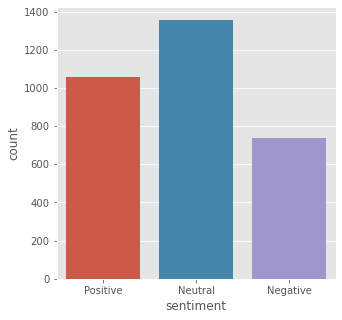

In [41]:
#visualize

fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = gop_tweet)

Text(0.5, 1.0, 'Distribution of sentiments')

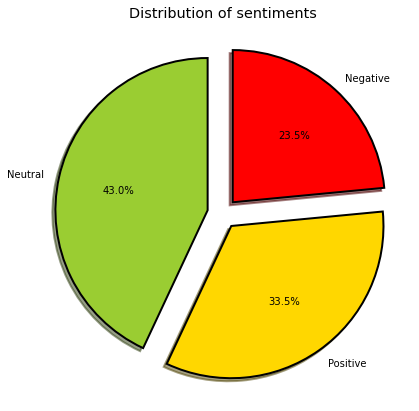

In [42]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = gop_tweet['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [43]:
from pathlib import Path  
filepath = Path('~sharraeallen/Documents/Ironhack_Classwork/Projects/Final_Project/gop_tweets.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
gop_tweet.to_csv(filepath)  

In [44]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [45]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Positive Tweets

In [46]:
# wordclouds
from wordcloud import WordCloud

pos_gop = gop_tweet[gop_tweet.sentiment == 'Positive']
pos_gop = pos_gop.sort_values(['polarity'], ascending= False)
pos_gop.head()

,tweet,polarity,sentiment
1612,school choice empowers students find learning ...,1.0,Positive
2943,part democrats plan silence parents school chi...,1.0,Positive
542,awesome job team went beyond prepare election ...,1.0,Positive
1172,said best need everyone engaged elections get ...,1.0,Positive
1589,1 percent voters view bidens economy excellent...,1.0,Positive


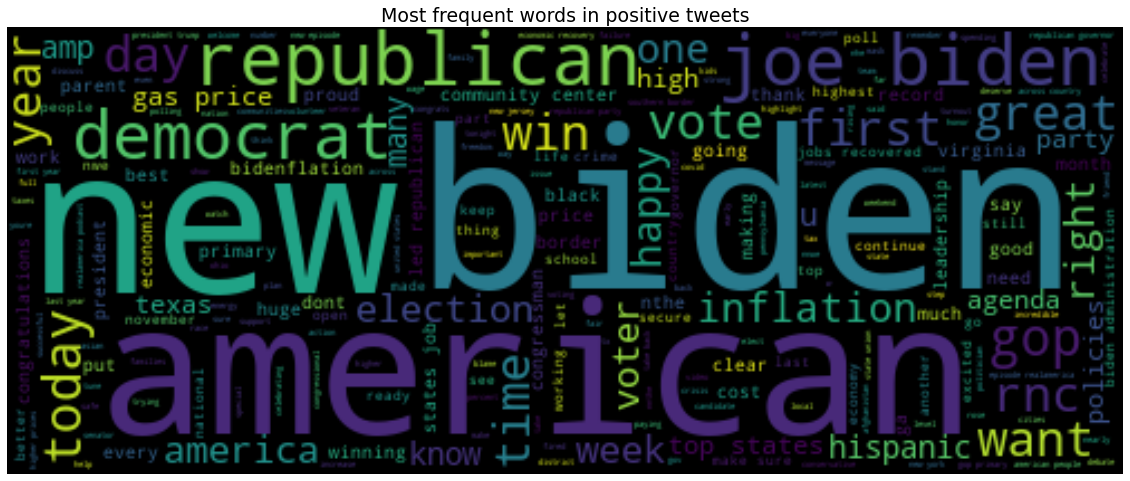

In [48]:
text_pos = ' '.join([word for word in pos_gop['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=300, width=500, height=200).generate(text_pos)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

### Neutral Tweets

In [50]:
neu_gop = gop_tweet[gop_tweet.sentiment == 'Neutral']
neu_gop = neu_gop.sort_values(['polarity'], ascending= False)
neu_gop.head()

,tweet,polarity,sentiment
3,apa community finding home republican party nd...,0.0,Neutral
2127,president trump handed bidennnthree vaccinesna...,0.0,Neutral
2146,everywhere go prices highern nbidenflation,0.0,Neutral
2145,red states leadingnblue states cant keep nbide...,0.0,Neutral
2144,eighth day crisesjoe biden gave americans risi...,0.0,Neutral


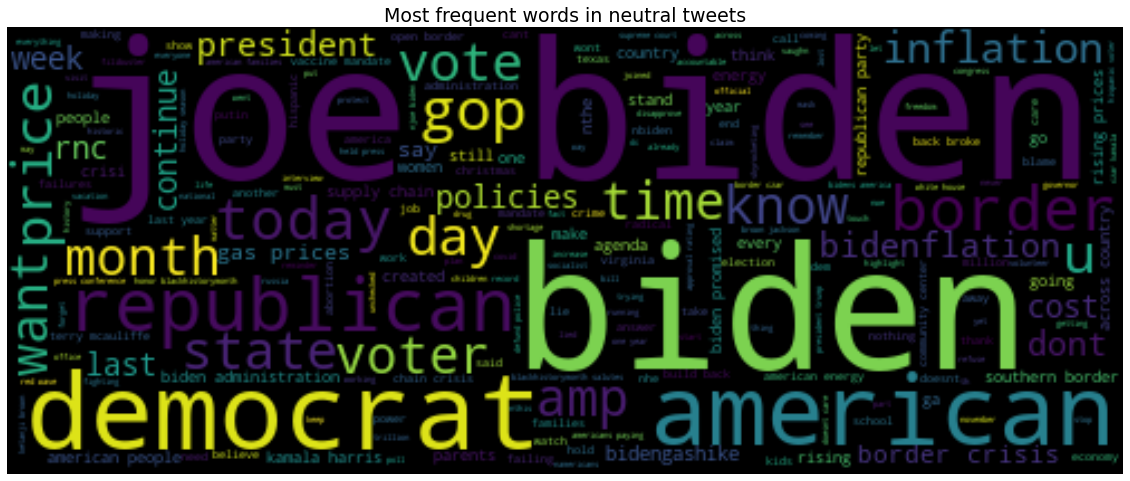

In [51]:
text_neu = ' '.join([word for word in neu_gop['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=300, width=500, height=200).generate(text_neu)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

### Negative Tweets 

In [52]:
neg_gop = gop_tweet[gop_tweet.sentiment == 'Negative']
neg_gop = neg_gop.sort_values(['polarity'], ascending= False)
neg_gop.head()

,tweet,polarity,sentiment
1191,made cleveland oh black american community cen...,-0.004167,Negative
2558,bidens approval rating reached new low abc new...,-0.010101,Negative
2021,tx gop govs using state resources protect cons...,-0.012500,Negative
253,pence honored open new jewish community center...,-0.012727,Negative
2111,gift american families holiday season sky high...,-0.013333,Negative


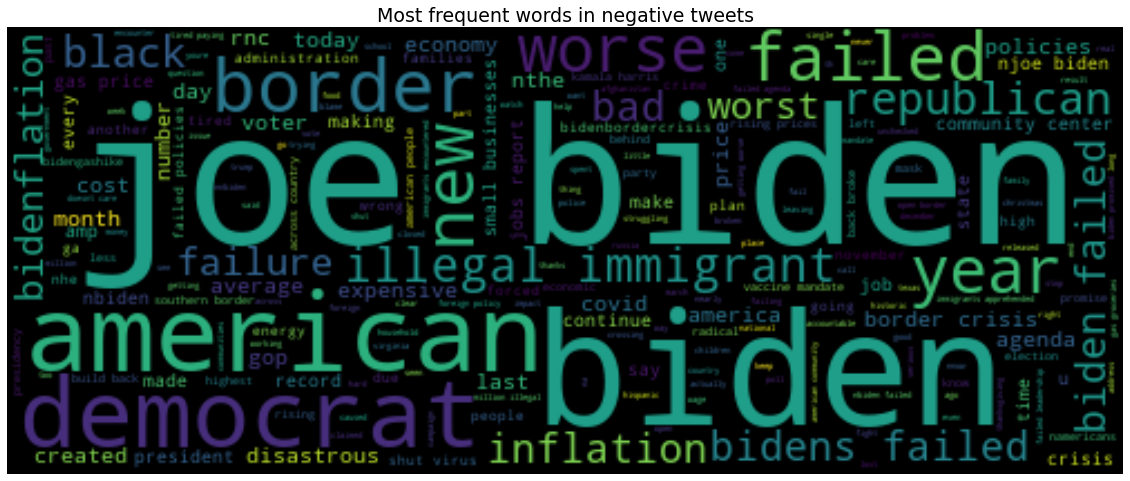

In [53]:
text_neg = ' '.join([word for word in neg_gop['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=300, width=500, height=200).generate(text_neg)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

# Logistic Regression Model

In [54]:
#vectorize for a bigram model, using 2 words
vect = CountVectorizer(ngram_range=(1,2)).fit(gop_tweet['tweet'])

In [55]:
#extract features
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 30 features:\n {}".format(feature_names[:30]))

Number of features: 26994

First 30 features:
 ['016', '016 4th', '040n', '040n bacon', '050n', '050n eggs', '0n', '0nn', '0nn supply', '10', '10 americans', '10 friends', '10 months', '10 percent', '10 states', '10 weeks', '10 worst', '100', '100 americans', '100 days', '100 field', '100 million', '100 officers', '100 times', '1000', '1000 2021', '1000 energy', '1000 last', '100000000000', '100000000000 stolen']


In [56]:
#build model
X = gop_tweet['tweet']
y = gop_tweet['sentiment']
X = vect.transform(X)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [58]:
print("Size of x_train:", (X_train.shape))
print('Size of y_train:', (y_train.shape))
print('Size of x_test:', (X_test.shape))
print('Size of y_test:', (y_test.shape))

Size of x_train: (2520, 26994)
Size of y_train: (2520,)
Size of x_test: (631, 26994)
Size of y_test: (631,)


In [59]:
#Train model using Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print('Test accuracy: {:.2f}%'.format(logreg_acc*100))

Test accuracy: 76.55%


In [60]:
#print confusion matrix to predict sentiment classification
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 85  54  16]
 [  1 246  15]
 [  7  55 152]]


              precision    recall  f1-score   support

    Negative       0.91      0.55      0.69       155
     Neutral       0.69      0.94      0.80       262
    Positive       0.83      0.71      0.77       214

    accuracy                           0.77       631
   macro avg       0.81      0.73      0.75       631
weighted avg       0.79      0.77      0.76       631



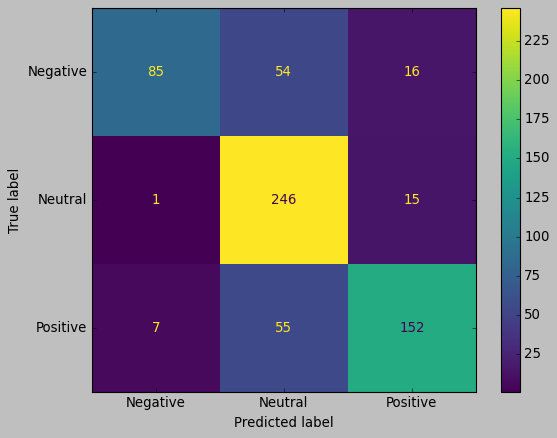

In [61]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [270]:
gop_tweet.to_csv('gop_sentiment_final.csv', index= False)

### Hyperparameter Tuning

In [269]:
#Use GridSearchCV for hyperparameter tuning

from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(gamma='auto'), param_grid)
grid.fit(x_train, y_train)

# Export Data

In [62]:
pos_gop.to_csv('positive_gop.csv', index= False)
neu_gop.to_csv('neutral_gop.csv', index= False)
neg_gop.to_csv('negative_gop.csv', index= False)